In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import os
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Mount data from drive
from google.colab import drive
drive.mount('/content/drive')

# Se cambia la ubicación del directorio raiz
os.chdir("/content/drive/MyDrive/MCD-TPs-Grupo/Series temporales/")  # Ubicación para CDB



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Ejercicio N°1
**Buscar dos series de tiempo y exponer la problemática de interés analítico (es importante detallar cuáles fueron los motivos de elección y situar al lector en el contexto adecuado).**

Por motivos de prolijidad se desarrollará el analisis de las dos series por separado. En esta instancia se utilizará:

* **Throughput_User_Dl:** Velocidad de bajada [Mbps] promedio por usuario

In [4]:
df_raw = pd.read_csv("data2.txt",sep='\t') 
df_raw.head(3)

,dateday,LNCEL_NAME,Throughput_User_Dl,DL_Traffic
0,05/07/2021,ZRSGREN12,13.677419,6695.176138
1,06/07/2021,ZRSGREN12,13.543080,8979.968913
2,07/07/2021,ZRSGREN12,14.366952,10161.793800


### Comparacion de las series

Antes de iniciar el análisis de la metrica elegida se comparan las metricas entre ellas

In [5]:
fig = px.scatter(df_raw, x="DL_Traffic", y="Throughput_User_Dl",
                 labels=dict(DL_Traffic="Trafico DL [MBytes]", Throughput_User_Dl="Thrp DL por usuario [Mbps]"))
fig.show()

### Selección de la métrica

In [6]:
# SELECCION DE LA SERIE
serie_elegida='Throughput_User_Dl'

In [7]:
# Se seleccionan los dos campos
df_raw=df_raw[['dateday',serie_elegida]]
df_raw.rename(columns = {'dateday':'day', serie_elegida:serie_elegida}, inplace = True)

# Convertimos el campo dateday a fecha
df_raw['day'] = pd.to_datetime(df_raw['day'], dayfirst = True) 

# la fecha la metemos como indice, esto nos va a permitir usar la funcion asfreq mas adelante
df_raw.set_index("day", inplace=True)

# Utilizo la funcion asfreq para darle el formato de serie temporal
df_raw=df_raw.asfreq('d')

df_raw.head(3)

,Throughput_User_Dl
day,
2021-07-05,13.677419
2021-07-06,13.543080
2021-07-07,14.366952


# Ejercicio N° 2
**Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias. Exponer los conceptos relacionados con la estacionariedad de la serie.**

In [8]:
def test_stationarity(timeseries):

    #Rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

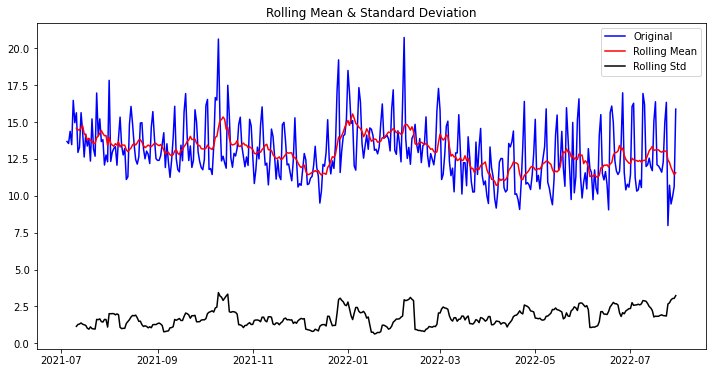

In [9]:
test_stationarity(df_raw[serie_elegida])

Se observa que la std es muy inestable. Por lo tanto se debe aplicar Box-Cox para estabilizarla

In [10]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(
    go.Scatter(x=df_raw.index, y=df_raw[serie_elegida], mode='lines', name='Serie'),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df_raw[serie_elegida],histnorm='percent',name='Histograma'),
    row=2, col=1
)


fig.update_layout(height=600, width=800, title_text=serie_elegida,
                  legend=dict(orientation="h",yanchor="bottom", y=1.02,xanchor="right",x=1)
                  )
fig.show()

### 2.1 Estacionariedad en la varianza - Box-Cox

Según la metodología de Box Jenkins, se comenta que antes de proceder al análisis de estacionariedad en la tendencia se debe verificar la estacionariedad den la varianza o la homcedaticidad mediante alguna prueba de Box-Cox.

Para esto se basó en el siguiente articulo: https://machinelearningmastery.com/power-transform-time-series-forecast-data-python/

In [11]:
from scipy.stats import boxcox

In [12]:
serie_box_cox=serie_elegida+'_box_cox'

df_raw[serie_box_cox], lam = boxcox(df_raw[serie_elegida])
print(lam)

-0.37281446943452956


y =

      | (x**lmbda - 1) / lmbda,  for lmbda != 0
      | log(x),                  for lmbda = 0


**References**
G.E.P. Box and D.R. Cox, "An Analysis of Transformations", Journal of the Royal Statistical Society B, 26, 211-252 (1964)

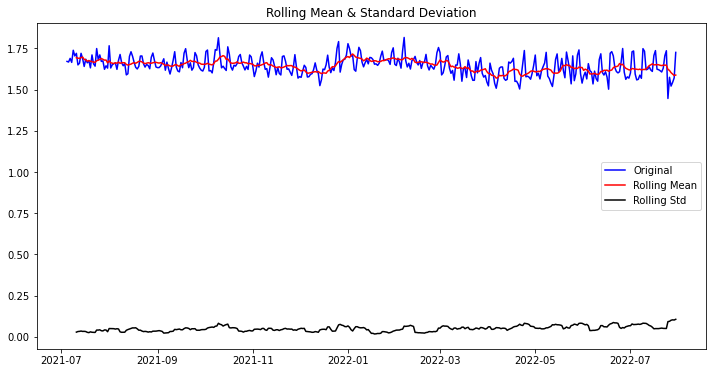

In [13]:
test_stationarity(df_raw[serie_box_cox])

In [14]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df_raw.index, y=df_raw[serie_elegida].rolling(7).std(),
                    mode='lines',yaxis='y1',
                    name="Original")
)

fig.add_trace(
    go.Scatter(x=df_raw.index, y=df_raw[serie_box_cox].rolling(7).std(),
                    mode='lines',yaxis='y2',
                    name="Box-Cox")
)

fig.update_layout(height=500, width=1000, title_text='Estacionariedad en la varianza Original vs Box-Cox',#create 1st y axis             
                  yaxis=dict(
                      title="Original axis"),
                                
                  #create 2nd y axis      
                  yaxis2=dict(title="Box-Cox axis",overlaying="y",side="right"),
                  legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
                  )
fig.show()

Se observa que luego de aplicar Box-Cox la std es mas estable (homocedasticidad)

In [15]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df_raw.index, y=df_raw[serie_elegida],
                    mode='lines',yaxis='y1',
                    name="Original")
)

fig.add_trace(
    go.Scatter(x=df_raw.index, y=df_raw[serie_box_cox],
                    mode='lines',yaxis='y2',
                    name="Box-Cox")
)

fig.update_layout(height=500, width=1000, title_text=serie_elegida,#create 1st y axis             
                  yaxis=dict(
                      title="Original axis"),
                                
                  #create 2nd y axis      
                  yaxis2=dict(title="Box-Cox axis",overlaying="y",side="right"),
                  legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
                  )
fig.show()

In [16]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(
    go.Histogram(x=df_raw[serie_elegida],histnorm='percent',name='Original'),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df_raw[serie_box_cox],histnorm='percent',name='Box-Cox'),
    row=2, col=1
)


fig.update_layout(height=600, width=800, title_text=serie_elegida,
                  legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
                  )
fig.show()

Otra forma de ver la normalidad es con un **QQ Plot**

In [17]:
import scipy.stats
import pylab

Text(0.5, 1.0, 'QQ Plot - Box Cox | Throughput ')

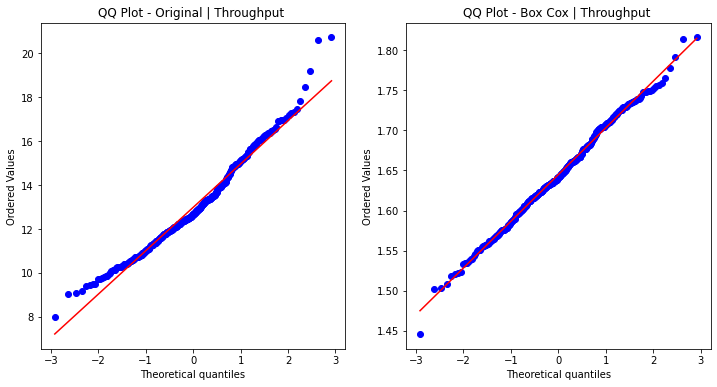

In [18]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
scipy.stats.probplot(df_raw[serie_elegida], plot = plt)
plt.title("QQ Plot - Original | Throughput ", size = 12)

plt.subplot(1,2,2)
scipy.stats.probplot(df_raw[serie_box_cox], plot = plt)
plt.title("QQ Plot - Box Cox | Throughput ", size = 12)

### 2.2 Estacionariedad en la tendencia

Para esto se utilizara el test de Dickie-Fuller aumentado. Se debe tener en cuenta que Ho= tiene raiz unitaria es decir que no es estacionario y hay que diferenciar

**Nota:** Aquí se ve que se tiene una constante distinta de cero con lo cual hay que especificar esa situación

In [19]:
import statsmodels.tsa.stattools as tsa

Aca sabemos que la serie no esta centrada en cero, es decir que tiene una constante de todas maneras se comparará con distintos métodos a fin de ver que tan lejos del rechazo da el resultado del test.

In [20]:
resultado = tsa.adfuller(df_raw[serie_box_cox], regression='n')
print('Evaluacion de raiz unitaria \nsin constante y sin pendiente \n')
print('Estadistico ADF: %f' % resultado[0])
print('p-valor: %f' % resultado[1])
print('Valores criticos:')
for key, valor in resultado[4].items():
  print('\t%s: %.3f' % (key, valor))

Evaluacion de raiz unitaria 
sin constante y sin pendiente 

Estadistico ADF: -0.533776
p-valor: 0.482191
Valores criticos:
	1%: -2.572
	5%: -1.942
	10%: -1.616


Se observa un p_value muy grande el cual se rechaza la Ho es decir hay que diferenciar

In [21]:
resultado = tsa.adfuller(df_raw[serie_box_cox], regression='c')
print('Evaluacion de raiz unitaria \ncon constante y sin pendiente \n')
print('Estadistico ADF: %f' % resultado[0])
print('p-valor: %f' % resultado[1])
print('Valores criticos:')
for key, valor in resultado[4].items():
  print('\t%s: %.3f' % (key, valor))

Evaluacion de raiz unitaria 
con constante y sin pendiente 

Estadistico ADF: -2.443233
p-valor: 0.129904
Valores criticos:
	1%: -3.448
	5%: -2.869
	10%: -2.571


Como ahora contempla la constante tiene un p_value mas chico pero de todas maneras indica que hay que diferenciar para lograr la estacionariedad.

In [22]:
resultado = tsa.adfuller(df_raw[serie_box_cox], regression='ct')
print('Evaluacion de raiz unitaria \ncon constante y con pendiente \n')
print('Estadistico ADF: %f' % resultado[0])
print('p-valor: %f' % resultado[1])
print('Valores criticos:')
for key, valor in resultado[4].items():
  print('\t%s: %.3f' % (key, valor))

Evaluacion de raiz unitaria 
con constante y con pendiente 

Estadistico ADF: -3.134123
p-valor: 0.098345
Valores criticos:
	1%: -3.983
	5%: -3.422
	10%: -3.134


Si ahora se considera tambien la pendiente el p_value es mas chico pero todavia no se puede rechazar la hipotesis Ho. Con lo cual hay que diferenciar

# Ejercicio N° 3
**Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de
los gráficos?. Justificar con teoría.**

In [23]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf

In [24]:
def grafica_FACx(serie,nrol=50):

  p1, axes=plt.subplots(3,1,figsize=(20,8),sharex=True, sharey=False )
  axes[2].set_xlabel('Lag')
  plot_acf(serie, lags=nrol, ax= axes[0], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title='FAC')
  plot_pacf(serie, lags=nrol, ax= axes[1], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='FACP', method='ywm')
  axes[2].plot(tsa.acovf(serie,fft=False, nlag=nrol), color='r', label='FAS')
  axes[2].set_title(label='FAS')
  axes[2].set_xticks(np.arange(1,nrol,2))

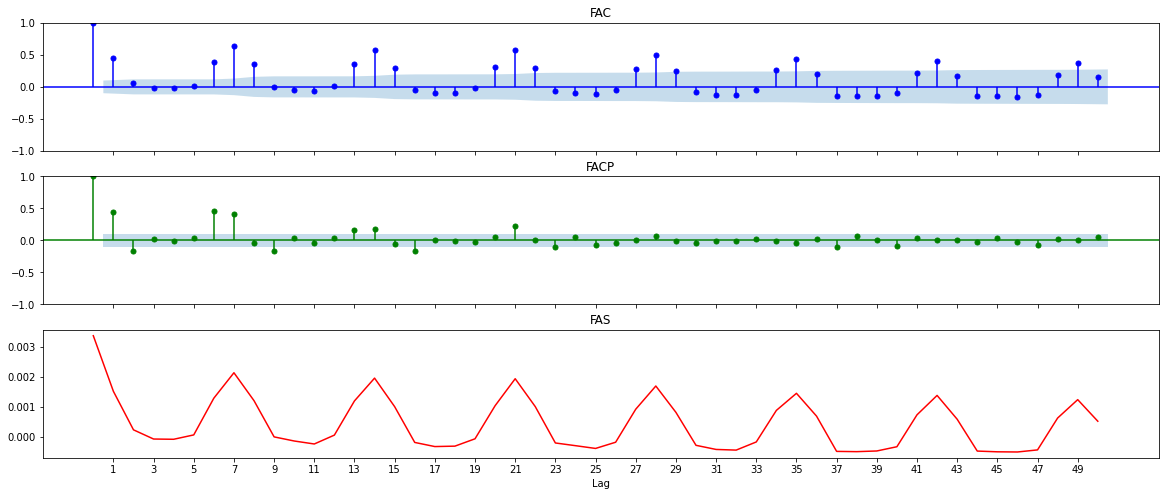

In [25]:
grafica_FACx(df_raw[serie_box_cox])

Se observa que la FAC no cae de manera exponencial indicando "no estaciona**R**iedad". Por otro lado se observa cierta periodicidad en la misma dando cierta evidencia de estaciona**L**idad

# Ejercicio N° 4
**Realizar distintas pruebas de raíces unitarias para determinar si las series elegidas son o no estacionarias.**

Ya en el **Ejercicio N°2** se realizaron las pruebas de Dickie - Fuller aumentado a fin de encontrar raices unitarias. En esa instancia se llegó a que **habia que diferenciar** al menos una vez

In [26]:
df_raw[['serie_diff1']]=df_raw[[serie_box_cox]].diff(axis = 0, periods = 1)

In [27]:
resultado = tsa.adfuller(df_raw['serie_diff1'].dropna(), regression='c')
print('Estadistico ADF: %f' % resultado[0])
print('p-valor: %f' % resultado[1])
print('Valores criticos:')
for key, valor in resultado[4].items():
  print('\t%s: %.3f' % (key, valor))

Estadistico ADF: -6.212209
p-valor: 0.000000
Valores criticos:
	1%: -3.448
	5%: -2.869
	10%: -2.571


In [28]:
resultado = tsa.adfuller(df_raw['serie_diff1'].dropna(), regression='ct')
print('Estadistico ADF: %f' % resultado[0])
print('p-valor: %f' % resultado[1])
print('Valores criticos:')
for key, valor in resultado[4].items():
  print('\t%s: %.3f' % (key, valor))

Estadistico ADF: -6.193467
p-valor: 0.000001
Valores criticos:
	1%: -3.983
	5%: -3.422
	10%: -3.134


en ambos casos se rechaza la Ho, con lo cual se considera que es **estacionario** y no hay que seguir diferenciando.

Esto mismo podriamos haberlo probado con distintos test

In [29]:
from pmdarima.arima import auto_arima, ndiffs, nsdiffs
from pmdarima.arima import ADFTest

In [30]:
n_adf = ndiffs(df_raw[serie_box_cox], test='adf')  # -> 0

# KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
n_kpss = ndiffs(df_raw[serie_box_cox], test='kpss')  # -> 0

# PP test: Phillips-Perron
n_pp = ndiffs(df_raw[serie_box_cox], test='pp')  # -> 0

print('Estimado de número de diferencias con ADF test')
print(n_adf)

print('Estimado de número de diferencias con KPSS test')
print(n_kpss)

print('Estimado de número de diferencias con PP test')
print(n_pp)

print('Se debe realizar diferenciación (should_diff) ADF Test')
adftest = ADFTest(alpha=0.05)
print(adftest.should_diff(df_raw[serie_box_cox]))

Estimado de número de diferencias con ADF test
1
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.09839885679531057, True)


Aquí se observa que tanto ADF y KPSS tambien recomiendo diferenciar una vez

### Graficando nuevamente la serie diferenciada

In [31]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=df_raw.index, y=df_raw[serie_elegida], mode='lines', name='Original'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df_raw.index, y=df_raw[serie_box_cox],mode='lines',name='Box-Cox'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=df_raw.index, y=df_raw['serie_diff1'],mode='lines',name='Box-Cox diff1'),
    row=3, col=1
)

fig.update_layout(height=800, width=1000, title_text=serie_elegida,
                  legend=dict(
                      orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
fig.show()

### Graficando las autocorrelaciones

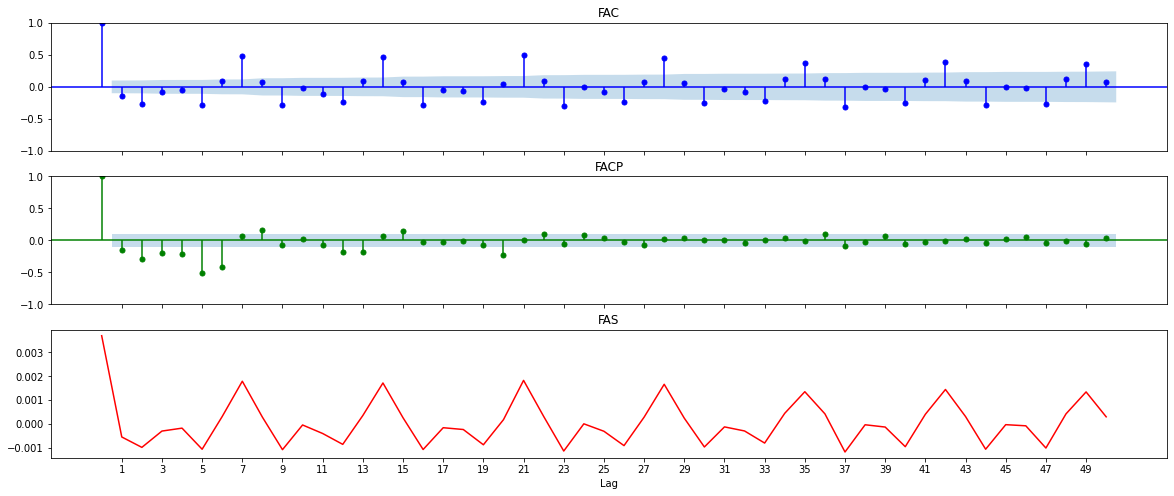

In [32]:
grafica_FACx(df_raw['serie_diff1'].dropna())

Se observa en el FAC que hay una periodicidad cada 7 muestras o días. Esto tiene sentido con la naturaleza del Proceso que se esta analizando debido a que el Throughput está invesamente relacionado con el tráfico y este último tiene un perfil semanal siendo el sábado y domingo los dias de menor trafico en celdas de ciudad

## Parte estacional

Se testea con nsdiffs, la cantidad de veces que hay que diferenciar para remover la parte estacional de 7 lags

In [33]:
nsdiffs(df_raw['serie_diff1'].dropna(), m=7) 

0

No es necesario diferenciarlo en la parte estacional, de todas maneras se hace una prueba para ver como quedaría la autocorrelación

In [34]:
df_raw[['serie_diff7']]=df_raw[['serie_diff1']].diff(axis = 0, periods = 7)

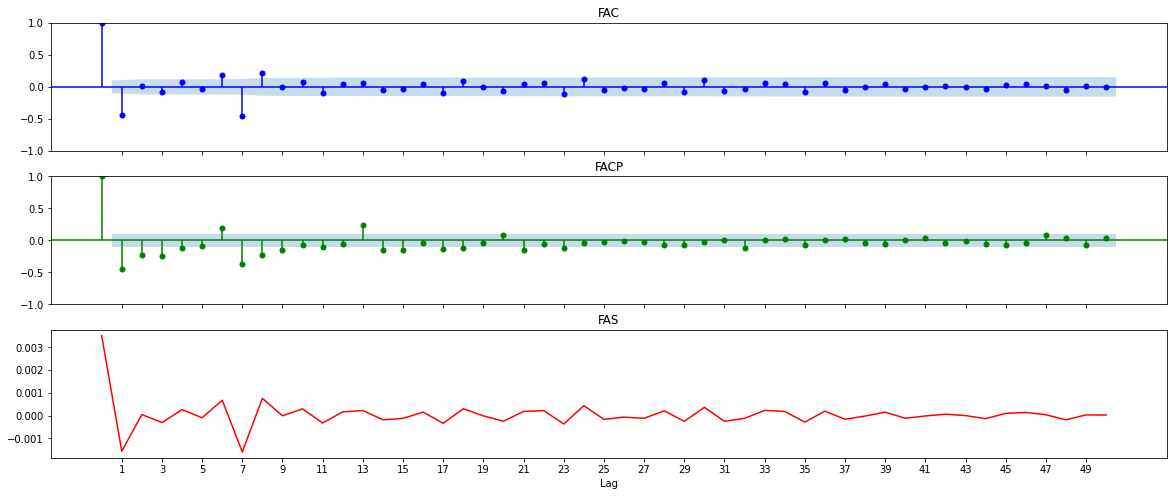

In [35]:
grafica_FACx(df_raw['serie_diff7'].dropna())

Se comprueba estacionariedad con lo cual no hay que diferenciarlo nuevamente

# Ejercicio 5 y 6

Se unen estos ejercicios debido a que primero se realizará una separacion del dataset entre **train-test**. De esta manera se utilizará el **test** para comparar las distintas performace de los distintos modelos. Por otro lado se utilizará el train ya sea para el auto_arima como para la seleccion manual de distintos modelos 

### Separacion train - test
Esta separación se realizara en un 90 train - 10 de test. 

In [36]:
p=0.9

df_raw['split']='train'

# Se calcula dentro del porcentaje train-test una cantidad completa de ciclos
df_raw['split'].iloc[round(df_raw.shape[0]*p/7)*7:]='test'

In [37]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df_raw[df_raw['split']=='train'].index, y=df_raw[df_raw['split']=='train'][serie_box_cox],
                    mode='lines',line=dict(color="#1E2FF6", width=3),
                    name='Train')
)

fig.add_trace(
    go.Scatter(x=df_raw[df_raw['split']=='test'].index, y=df_raw[df_raw['split']=='test'][serie_box_cox],
                    mode='lines', line=dict(color="#FF0000", width=3), # dash='dot'
                    name='Test')
)

fig.update_layout(height=500, width=1000, title_text="Train - Test split",
                  legend=dict(orientation="h", yanchor="bottom",y=1.02,xanchor="right",x=1))
fig.show()

Dentro del train se separará en train Validacion a fin de hacer cross validation. Para esto se seleccionará 4 folds de tres ciclos cada uno (28 muestras) y se dejará un ciclo a fin de separar el train del test 

In [38]:
from sklearn.model_selection import TimeSeriesSplit

In [39]:
n_splits=3
test_size=7*4
gap=7

max_train_size=df_raw[df_raw['split']=='train'].shape[0]-gap-test_size*n_splits

tscv = TimeSeriesSplit(n_splits=n_splits,gap=gap, test_size=test_size,max_train_size=max_train_size)

In [40]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

for i,(train_index, test_index) in enumerate(tscv.split(df_raw[df_raw['split']=='train'][serie_box_cox])):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
    # print("TRAIN:", train_index, "TEST:", test_index)
    fig.add_trace(
        go.Scatter(x=df_raw.iloc[train_index].index, y=df_raw.iloc[train_index][serie_box_cox], mode='lines', name='Train',showlegend=(i==0),line=dict(color="#1E2FF6", width=3)),
        row=(i+1), col=1
    )

    fig.add_trace(
        go.Scatter(x=df_raw.iloc[test_index].index, y=df_raw.iloc[test_index][serie_box_cox],mode='lines',name='Validation',showlegend=(i==0), line=dict(color="#FF0000", width=3)),
        row=(i+1), col=1
    )
  

fig.update_xaxes(rangemode='tozero')
fig.update_layout(height=800, width=1000, title_text=serie_elegida,
                  legend=dict(
                      orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
fig.show()

TRAIN: (259,) TEST: (28,)
TRAIN: (259,) TEST: (28,)
TRAIN: (259,) TEST: (28,)


https://medium.com/@dave.cote.msc/rdr-score-metric-for-evaluating-time-series-forecasting-models-1c23f92f80e7

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [42]:
# Esto se comenta porque tarda mucho pero es la forma de buscar los parametros mediante cross validation

# df_res=pd.DataFrame([],columns=['p','i','q','P','I','Q','MAE','AIC','MSE','RMSE','MAPE'])

# for p in [0,1,2,3]:
#     print("p:"+str(p))
#     for q in [0,1,2,3]:
#         for P in [0,1,2,3]:
#             for Q in [0,1,2,3]:
#                 MAE=[]
#                 AIC=[]
#                 MSE=[]
#                 RMSE=[]
#                 MAPE=[]
#                 for i,(train_index, test_index) in enumerate(tscv.split(df_raw[df_raw['split']=='train'][serie_box_cox])):
#                     modelo = SARIMAX(df_raw.iloc[train_index][serie_box_cox], order=(p,1,q), seasonal_order=(P,0,Q,7))
#                     modelo_fit = modelo.fit()
#                     prediccion = modelo_fit.get_forecast(test_size+gap)
#                     MAE.append(mean_absolute_error(df_raw.iloc[test_index][serie_box_cox], prediccion.predicted_mean[7:]))
#                     AIC.append(modelo_fit.aic)
#                     MSE.append(mean_squared_error(df_raw.iloc[test_index][serie_box_cox], prediccion.predicted_mean[7:]))
#                     RMSE.append(np.sqrt(mean_squared_error(df_raw.iloc[test_index][serie_box_cox], prediccion.predicted_mean[7:])))
#                     MAPE.append(np.mean(abs((df_raw.iloc[test_index][serie_box_cox]- prediccion.predicted_mean[7:])/df_raw.iloc[test_index][serie_box_cox])))
#                     # print(modelo_fit.summary())

#                 mae=sum(MAE)/3
#                 aic=sum(AIC)/3
#                 mse=sum(MSE)/3
#                 rmse=sum(RMSE)/3
#                 mape=sum(MAPE)/3
#                 df_res=pd.concat([df_res,pd.DataFrame([[p,1,q,P,0,Q,mae,aic,mse,rmse,mape]],columns=['p','i','q','P','I','Q','MAE','AIC','MSE','RMSE','MAPE'])])

In [43]:
#Se exporta una vez para generar el archivo, despues directamente se puede leer el resultado
# df_res.to_csv('resultados_thp.csv')

df_res=pd.read_csv('resultados_thp.csv')

In [44]:
df_res[df_res['MAE']==df_res['MAE'].min()]

,Unnamed: 0,p,i,q,P,I,Q,MAE,AIC,MSE,RMSE,MAPE
122,0,1,1,3,2,0,2,0.034855,-998.448001,0.001879,0.04321,0.021613


In [45]:
df_res[df_res['AIC']==df_res['AIC'].min()]

,Unnamed: 0,p,i,q,P,I,Q,MAE,AIC,MSE,RMSE,MAPE
37,0,0,1,2,1,0,1,0.036042,-1005.554281,0.001983,0.044384,0.022382


In [46]:
p=df_res[df_res['MAE']==df_res['MAE'].min()]['p'].values[0]
q=df_res[df_res['MAE']==df_res['MAE'].min()]['q'].values[0]

P=df_res[df_res['MAE']==df_res['MAE'].min()]['P'].values[0]
Q=df_res[df_res['MAE']==df_res['MAE'].min()]['Q'].values[0]

In [47]:
modelo_optimo = SARIMAX(df_raw[df_raw['split']=='train'][serie_box_cox], order=(p,1,q), seasonal_order=(P,0,Q,7))
modelo_optimo_fit = modelo_optimo.fit(maxiter=200)
print(modelo_optimo_fit.summary())
prediccion_opt = modelo_optimo_fit.get_forecast(df_raw[df_raw['split']=='test'].shape[0])

                                       SARIMAX Results                                        
Dep. Variable:             Throughput_User_Dl_box_cox   No. Observations:                  350
Model:             SARIMAX(1, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood                 660.239
Date:                                Sun, 07 Aug 2022   AIC                          -1302.478
Time:                                        15:25:42   BIC                          -1267.782
Sample:                                    07-05-2021   HQIC                         -1288.666
                                         - 06-19-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4455      4.264      0.104      0.917      -7.912       8.803
ma.

In [48]:
def plot_prediction(df,serie,prediction,espectral=False):
    fig = go.Figure()

    if espectral:
      df_espectral=df[df['split']=='test']['espectral'].values
    else:
      df_espectral=0

    fig.add_trace(
        go.Scatter(x=df[df['split']=='train'].index, y=df[df['split']=='train'][serie],
                        mode='lines',line=dict(color="#1E2FF6", width=3),name='Train')
    )

    fig.add_trace(
        go.Scatter(x=df[df['split']=='test'].index, y=df[df['split']=='test'][serie],
                        mode='lines',line=dict(color="#FF0000", width=3),name='Test')
    )

    fig.add_trace(
        go.Scatter(x=df[df['split']=='test'].index, y=prediction.predicted_mean+df_espectral,
                        mode='lines',line=dict(color='rgba(0, 0, 0,1)', width=3),name='Prediction')
    )


    fig.add_traces([go.Scatter(x = df[df['split']=='test'].index, y = prediction.conf_int(alpha=0.05).iloc[:,1]+df_espectral,
                              mode = 'lines', line=dict(color='rgba(0,0,0,0.5)', width=1),
                              showlegend = False),
                    go.Scatter(x = df[df['split']=='test'].index, y = prediction.conf_int(alpha=0.05).iloc[:,0]+df_espectral,
                              mode = 'lines', line=dict(color='rgba(0,0,0,0.5)', width=1),
                              name = '95% confidence interval',fill='tonexty', fillcolor = 'rgba(0, 0, 0, 0.2)')])

    fig.update_layout(height=500, width=1000, title_text="Train - Test split",
                      legend=dict(
                          orientation="h",
                          yanchor="bottom",
                          y=1.02,
                          xanchor="right",
                          x=1
                      ))
    fig.show()

In [49]:
plot_prediction(df_raw,serie_box_cox,prediccion_opt)

### Metricas

In [50]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

In [51]:
evaluar_metricas(df_raw[df_raw['split']=='test'][serie_box_cox], prediccion_opt.predicted_mean)

MSE: 0.002193983852525418
MAE: 0.03638653992773278
RMSE: 0.04683998134633935
MAPE: 0.0223


### Residuos

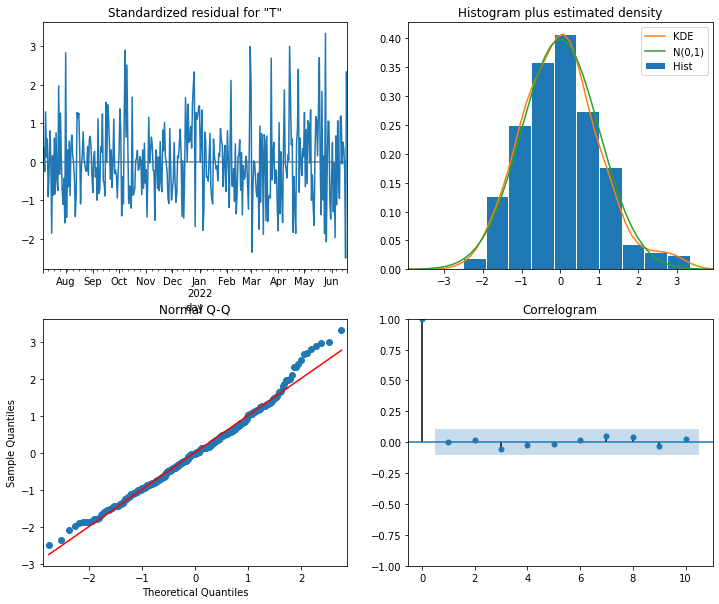

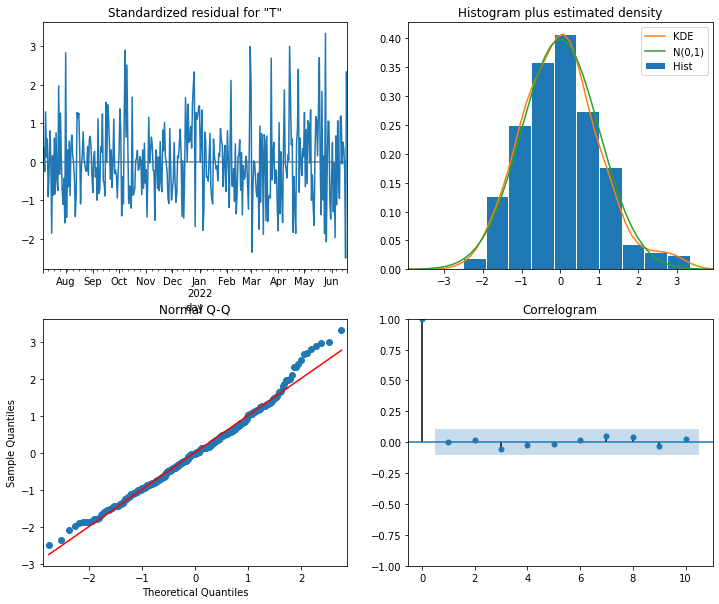

In [52]:
modelo_optimo_fit.plot_diagnostics(figsize=(12,10))

Se observan que los residuos son practicamente normales y no se encuentran correlacionados (correlograma con componente solo en el origen). Con esto se da por finalizado la metodologia de Box-Jenkinks

# Ejercicio 7
**Detallar una comparación con otros modelos estimados.**

### Autoarima

In [53]:
from pmdarima.arima import auto_arima, ndiffs, nsdiffs

In [54]:
auto_arima(df_raw[df_raw['split']=='train'][serie_box_cox], start_p=0, max_p=5, start_d=0, max_d=3, start_q=0, max_q=5, 
           start_P=0, max_P=5, start_D=0, max_D=3, start_Q=0, max_Q=7,seasonal=True, m=7, trace=True, stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-997.388, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-1124.649, Time=1.12 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-1150.741, Time=1.86 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-999.385, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-1070.586, Time=0.67 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-1299.526, Time=3.20 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-1209.331, Time=2.21 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=-1270.947, Time=4.58 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-1267.504, Time=4.47 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-1178.260, Time=4.51 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=-1244.421, Time=2.96 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=-1292.240, Time=6.27 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.96 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=-1266.601, Time=2.81 sec
 ARIMA(0,1,2)(1,0,1)[7] int

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  350
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                 659.716
Date:                           Sun, 07 Aug 2022   AIC                          -1309.431
Time:                                   15:26:55   BIC                          -1290.156
Sample:                                        0   HQIC                         -1301.758
                                           - 350                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1404      0.054      2.583      0.010       0.034       0.247
ma.L1         -0.8716      0.027    -32.102      0.000      -0.925      -0.818
ar.S.L7        0.9951      0.006    161.133      0.000       0.983       1.007
ma.S.L7       -0.8934      0.043    -20.640      0.000      -0.978      -0.809
sigma2         0.0013   8.51e-05     14.763      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                14.98
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
modelo_auto = SARIMAX(df_raw[df_raw['split']=='train'][serie_box_cox], order=(1,1,1), seasonal_order=(1,0,1,7))
modelo_auto_fit = modelo_auto.fit(maxiter=200)
prediccion_auto = modelo_auto_fit.get_forecast(df_raw[df_raw['split']=='test'].shape[0])
# print(modelo_auto_fit.summary())

https://stats.stackexchange.com/questions/84076/negative-values-for-aic-in-general-mixed-model

In [56]:
plot_prediction(df_raw,serie_box_cox,prediccion_auto)

In [57]:
evaluar_metricas(df_raw[df_raw['split']=='test'][serie_box_cox], prediccion_auto.predicted_mean)

MSE: 0.0021539765324006493
MAE: 0.03618116910743728
RMSE: 0.0464109527202432
MAPE: 0.0222


### Metodo media movil simple

Se utilizará una ventana de 7 a fin de que coincida con la naturaleza ciclicla del proceso

In [58]:
ma_window=7
df_raw['sma_forecast'] = df_raw[serie_box_cox].rolling(ma_window).mean()
df_raw.loc[df_raw[df_raw['split']=='test'].index,'sma_forecast']=df_raw[df_raw['split']=='train']['sma_forecast'].tail(1).values[0]

In [59]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df_raw[df_raw['split']=='train'].index, y=df_raw[df_raw['split']=='train'][serie_box_cox],
                    mode='lines',line=dict(color="#1E2FF6", width=3),name='Train')
)

fig.add_trace(
    go.Scatter(x=df_raw[df_raw['split']=='test'].index, y=df_raw[df_raw['split']=='test'][serie_box_cox],
                    mode='lines',line=dict(color="#FF0000", width=3),name='Test')
)

fig.add_trace(
    go.Scatter(x=df_raw.index, y=df_raw['sma_forecast'],
                    mode='lines',line=dict(color='rgba(0, 0, 0,1)', width=3),name='Prediction')
)


fig.update_layout(height=500, width=1000, title_text="Train - Test split",
                  legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right", x=1))
fig.show()

In [60]:
evaluar_metricas(df_raw[df_raw['split']=='test'][serie_box_cox],df_raw[df_raw['split']=='test']['sma_forecast'])

MSE: 0.00501732038494934
MAE: 0.05377539517363382
RMSE: 0.070833045853961
MAPE: 0.0327


### Naive

In [61]:
df_raw['naive_forecast'] = df_raw[serie_box_cox]
df_raw.loc[df_raw[df_raw['split']=='test'].index,'naive_forecast']=df_raw[df_raw['split']=='train']['naive_forecast'].tail(1).values[0]

In [62]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df_raw[df_raw['split']=='train'].index, y=df_raw[df_raw['split']=='train'][serie_box_cox],
                    mode='lines',line=dict(color="#1E2FF6", width=3),name='Train')
)

fig.add_trace(
    go.Scatter(x=df_raw[df_raw['split']=='test'].index, y=df_raw[df_raw['split']=='test'][serie_box_cox],
                    mode='lines',line=dict(color="#FF0000", width=3),name='Test')
)

fig.add_trace(
    go.Scatter(x=df_raw.index, y=df_raw['naive_forecast'],
                    mode='lines',line=dict(color='rgba(0, 0, 0,1)', width=3,dash='dot'),name='Prediction')
)


fig.update_layout(height=500, width=1000, title_text="Train - Test split",
                  legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right", x=1))
fig.show()

In [63]:
evaluar_metricas(df_raw[df_raw['split']=='test'][serie_box_cox],df_raw[df_raw['split']=='test']['naive_forecast'])

MSE: 0.015206919659738641
MAE: 0.10418575789703668
RMSE: 0.12331633979217288
MAPE: 0.0658


### Naive estacional

In [64]:
df_raw['naive_est_forecast'] = df_raw[serie_box_cox]
df_raw.loc[df_raw[df_raw['split']=='test'].index,'naive_est_forecast']=df_raw.iloc[df_raw[df_raw['split']=='train'].shape[0]-6+(df_raw[df_raw['split']=='test'].reset_index().index%7)]['naive_est_forecast'].values

In [65]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df_raw[df_raw['split']=='train'].index, y=df_raw[df_raw['split']=='train'][serie_box_cox],
                    mode='lines',line=dict(color="#1E2FF6", width=3),name='Train')
)

fig.add_trace(
    go.Scatter(x=df_raw[df_raw['split']=='test'].index, y=df_raw[df_raw['split']=='test'][serie_box_cox],
                    mode='lines',line=dict(color="#FF0000", width=3),name='Test')
)

fig.add_trace(
    go.Scatter(x=df_raw.index, y=df_raw['naive_est_forecast'],
                    mode='lines',line=dict(color='rgba(0, 0, 0,1)', width=3,dash='dot'),name='Prediction')
)


fig.update_layout(height=500, width=1000, title_text="Train - Test split",
                  legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right", x=1))
fig.show()

In [66]:
evaluar_metricas(df_raw[df_raw['split']=='test'][serie_box_cox],df_raw[df_raw['split']=='test']['naive_est_forecast'])

MSE: 0.004981532982231973
MAE: 0.05576504351357202
RMSE: 0.07057997578798092
MAPE: 0.0348


# Ejercicio N°8
**Efectuar un Análisis de Diagnóstico de las series temporales (Análisis sobre los Residuos del modelo,
análisis gráfico de FAC, test de Ljung-Box, etc.).**

Se analizará solamente el mejor modelo que es el autoarima

In [67]:
print(modelo_auto_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:        Throughput_User_Dl_box_cox   No. Observations:                  350
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                 660.134
Date:                           Sun, 07 Aug 2022   AIC                          -1310.269
Time:                                   15:26:57   BIC                          -1290.993
Sample:                               07-05-2021   HQIC                         -1302.596
                                    - 06-19-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1623      0.055      2.957      0.003       0.055       0.270
ma.L1         -0.8721      0.028    -31.589

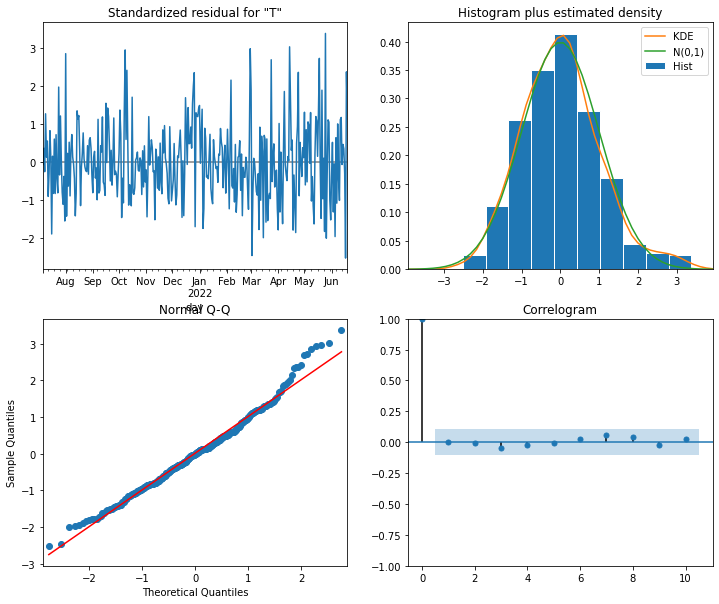

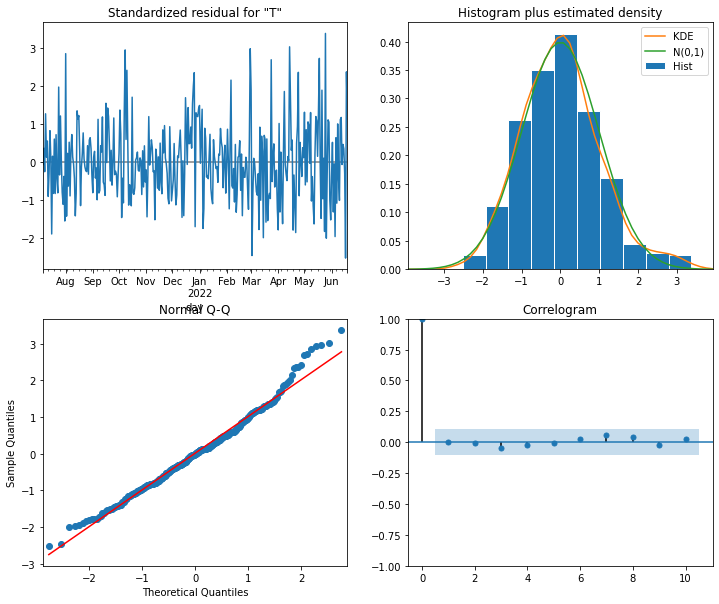

In [68]:
modelo_auto_fit.plot_diagnostics(figsize=(12,10))

Se observan que los residuos son normales, con media cero y no correlacionados. Es decir, se comporta como un ruido blanco. Esto da indicios de que los parámetros del modelo son los correctos

In [69]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [70]:
acorr_ljungbox(modelo_auto_fit.resid, lags=[2], return_df=True)

,lb_stat,lb_pvalue
2,0.042134,0.979153


No rechazo la hipotesis Ho y por lo tanto podemos decir que los residuos son independientes.
https://www.statology.org/ljung-box-test-python/

# Ejercicion N°9
**Pronosticar con el modelo seleccionado para cada serie para una ventana temporal razonable, en función de la periodicidad y el comportamiento de las mismas.**

Se estuvo realizando estos pronosticos con el dataset de test y verificando su performances para los distintos modelos en los ejercicios anteriores


# Apendice
Se realiza un analisis espectral a fin de descontar la estacionalidad de la serie y llegar a modelos mas parcimoniosos. Cabe aclarar que este analisis es **deterministico** y es solo a los efectos de un **feature engeneering**

In [71]:
from numpy.fft import fft, ifft

Se hace el analisis espectral de la serie para ver si tiene componenetes espectrales relevantes. 

In [72]:
fig = go.Figure()

fm=1 #muestras por días
Tm=1/fm
T=7 # periodo de la serie, cada 7 dias

x_n=df_raw[serie_box_cox]-df_raw[serie_box_cox].mean()
N=len(x_n)


X_f = fft(x_n)/N
k=np.concatenate([np.arange(0,N/2), np.arange(-N/2,0)]) # La funcion fft da las frecuences 0 a fn y -fn a 0 siendo fn la frecuencia de Nyquist
s=k/N*fm

fig = go.Figure()


fig.add_trace(
    go.Scatter( x=s,y=pd.Series(np.abs(X_f)),
                    mode='lines',yaxis='y1',
                    name="Imaginaria")
)

fig.update_layout(height=500, width=1000, title_text="Analisis espectral "+serie_box_cox,#create 1st y axis             
                  yaxis=dict(
                      title="Amplitud"),
                  )
fig.show()

Se observa del módulo del espectro picos de amplitud en en frecuencias determinada. Esta concentracion puntual en una frecuencia corresponde a armonicos de un serie y puedes ser representados por funciones sinusoidales. Aquí casualmente se observa el primer armonico en 1/7 (siendo 7 el período de la serie) y el segundo armonico en 2/7. Y sus valores de amplitud son 0.022 y 0.011 respectivamente.

Si graficamos la densidad espectral de dos funciones senoidales con estas frecuencias observamos que se encuentran posicionadas practicamente en el mismo lugar

### Cálculo de la Transformada de Fourier

In [94]:
fm=1 #muestras por días
Tm=1/fm
# n=np.arange(0,1000)
T=7 # periodo de la serie, cada 7 dias

mu=df_raw[serie_box_cox].mean()
print(mu)
x_n=df_raw[serie_box_cox]-mu
N=len(x_n)
X_f = fft(x_n)/N
k=np.concatenate([np.arange(0,N/2), np.arange(-N/2,0)]) # La funcion fft da las frecuences 0 a fn y -fn a 0 siendo fn la frecuencia de Nyquist
s=k/N*fm


1.6448998227770077


In [125]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=s, y=np.abs(X_f), mode='lines', name='Amplitud de X(f)'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=s, y=np.real(X_f),mode='lines',name='Parte real de X(f)'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=s, y=np.imag(X_f),mode='lines',name='Parte imaginaria de X(f)'),
    row=3, col=1
)

fig.update_layout(height=600, width=1000, title_text="Análisis espectral "+serie_box_cox,
                  legend=dict(
                      orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
fig.show()

Aquí se observa una gran amplitud para componentes de frecuencias particulares (armónicos). Es decir que la información periódica se podría sintetizar con sumas de senos y cosenos. Según las Series de Fourier y las ecuaciones de Euler se puede decir que la parte imaginaria se puede representar con senos y la parte real con cosenos ambos multiplicados por coeficientes correspondiente al doble de la amplitud que se observa en la transformada.

Si se inspecciona el vector de la fft se deduce que el primer y segundo armónico se dan en los siguientes indices

In [98]:
print("Módulo primer armonico: "+str(abs(X_f[56])))
print("Módulo primer armonico: "+str(abs(X_f[335])))
print("Módulo primer armonico: "+str(abs(X_f[112])))
print("Módulo primer armonico: "+str(abs(X_f[279])))

print("\nParte compleja primer armonico: "+str(X_f[56]))
print("Parte compleja primer armonico: "+str(X_f[335]))
print("Parte compleja segundo armonico: "+str(X_f[112]))
print("Parte compleja segundo armonico: "+str(X_f[279]))

Módulo primer armonico: 0.022523139328314287
Módulo primer armonico: 0.022523139328314287
Módulo primer armonico: 0.011896430864236843
Módulo primer armonico: 0.011896430864236848

Parte compleja primer armonico: (0.016692308506070074+0.01512146295636895j)
Parte compleja primer armonico: (0.016692308506070074-0.01512146295636895j)
Parte compleja segundo armonico: (0.001923014059534012+0.011739978033812562j)
Parte compleja segundo armonico: (0.0019230140595340127-0.011739978033812567j)


## Sintetización de la funcion periódica

In [126]:
f1=1/7
f2=2*f1

a1_real=np.real(X_f[56])
a1_imag=-np.imag(X_f[56])
a2_imag=-np.imag(X_f[112])
n=np.arange(0.5,N+0.5)
z_n=2*(a1_real*np.cos(2*np.pi*n*Tm*f1)+a2_imag*np.sin(2*np.pi*n*Tm*f2)+a1_imag*np.sin(2*np.pi*n*Tm*f1))
Z_f = fft(z_n)/N

In [128]:
fig = make_subplots(rows=2, cols=2)

fig.add_trace(
    go.Scatter(x=s, y=np.real(X_f), mode='lines', name='Amplitud de X(f)'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=s, y=np.imag(X_f),mode='lines',name='Parte real de X(f)'),
    row=1, col=2
)

# Sintetizado
fig.add_trace(
    go.Scatter(x=s, y=np.real(Z_f), mode='lines', name='Amplitud de Z(f)'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=s, y=np.imag(Z_f),mode='lines',name='Parte real de Z(f)'),
    row=2, col=2
)

fig.update_layout(height=600, width=1000, title_text="Análisis espectral "+serie_box_cox,
                  legend=dict(
                      orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
fig.show()

Finalmente se le agrega la media y se realiza la comparación con la serie original

In [129]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df_raw.index, y=df_raw[serie_box_cox],
                    mode='lines',yaxis='y1',
                    name="Original")
)

fig.add_trace(
    go.Scatter(x=df_raw.index, y=pd.Series(z_n+mu),
                    mode='lines',yaxis='y1',
                    name="Sintetizada")
)

fig.update_layout(height=500, width=1000, title_text=serie_elegida,#create 1st y axis             
                  yaxis=dict(
                      title="Original axis"),legend=dict(
                      orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
                  )
fig.show()

### Desafectación de la componenete periódica

Si ahora restamos 

In [112]:
df_raw['espectral']=pd.Series(z_n+mu).values

In [113]:
df_raw['resta']=df_raw[serie_box_cox]-df_raw['espectral']

In [114]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df_raw.index, y=df_raw['resta'],
                    mode='lines',yaxis='y1',
                    name="Original")
)


fig.update_layout(height=500, width=1000, title_text=serie_elegida,#create 1st y axis             
                  yaxis=dict(
                      title="Original axis")
                  )
fig.show()

In [132]:
resultado = tsa.adfuller(df_raw['resta'], regression='n')
print('Evaluacion de raiz unitaria \nsin constante y sin pendiente \n')
print('Estadistico ADF: %f' % resultado[0])
print('p-valor: %f' % resultado[1])
print('Valores criticos:')
for key, valor in resultado[4].items():
  print('\t%s: %.3f' % (key, valor))

Evaluacion de raiz unitaria 
sin constante y sin pendiente 

Estadistico ADF: -3.208574
p-valor: 0.001338
Valores criticos:
	1%: -2.572
	5%: -1.942
	10%: -1.616


In [134]:
resultado = tsa.adfuller(df_raw['resta'], regression='c')
print('Evaluacion de raiz unitaria \ncon constante y sin pendiente \n')
print('Estadistico ADF: %f' % resultado[0])
print('p-valor: %f' % resultado[1])
print('Valores criticos:')
for key, valor in resultado[4].items():
  print('\t%s: %.3f' % (key, valor))

Evaluacion de raiz unitaria 
con constante y sin pendiente 

Estadistico ADF: -3.201075
p-valor: 0.019923
Valores criticos:
	1%: -3.447
	5%: -2.869
	10%: -2.571


In [136]:
resultado = tsa.adfuller(df_raw['resta'], regression='ct')
print('Evaluacion de raiz unitaria \ncon constante y con pendiente \n')
print('Estadistico ADF: %f' % resultado[0])
print('p-valor: %f' % resultado[1])
print('Valores criticos:')
for key, valor in resultado[4].items():
  print('\t%s: %.3f' % (key, valor))

Evaluacion de raiz unitaria 
con constante y con pendiente 

Estadistico ADF: -3.822369
p-valor: 0.015462
Valores criticos:
	1%: -3.983
	5%: -3.422
	10%: -3.134


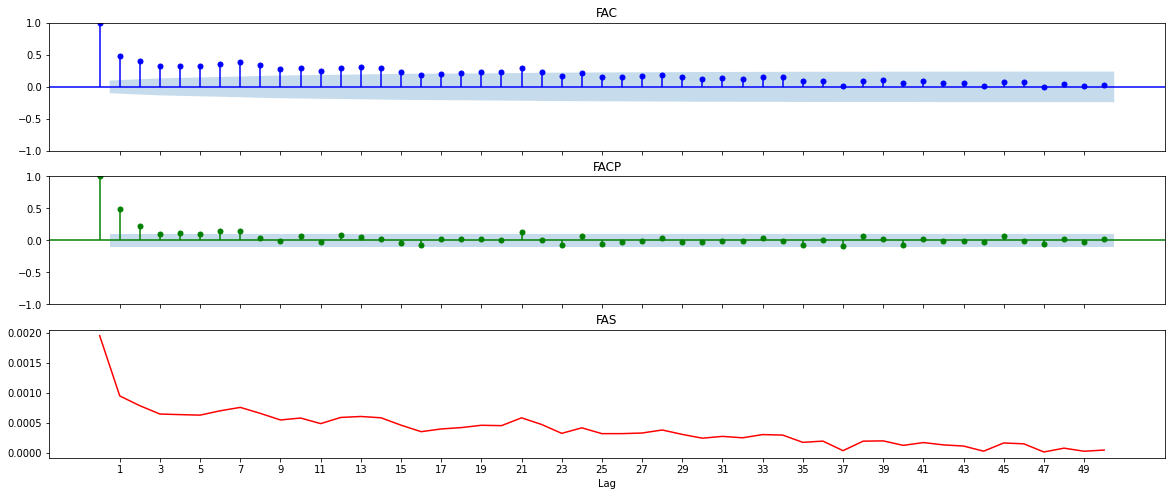

In [118]:
grafica_FACx(df_raw['resta'])

In [119]:
auto_arima(df_raw[df_raw['split']=='train']['resta'], start_p=0, max_p=5, start_d=0, max_d=1, start_q=0, max_q=5,seasonal=False, trace=True, stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1201.722, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1262.672, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1337.895, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1203.722, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1342.144, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1340.261, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1340.210, Time=0.68 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1342.144, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1284.735, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1338.382, Time=0.62 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1343.691, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1339.544, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1264.672, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1341.814, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  350
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 674.850
Date:                Sun, 07 Aug 2022   AIC                          -1343.700
Time:                        15:50:14   BIC                          -1332.134
Sample:                             0   HQIC                         -1339.096
                                - 350                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7108      0.045    -15.793      0.000      -0.799      -0.623
ma.L2         -0.1290      0.046     -2.791      0.005      -0.220      -0.038
sigma2         0.0012   8.48e-05     14.395      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.52
Prob(Q):                              1.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.90   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
modelo_espectral = SARIMAX(df_raw[df_raw['split']=='train']['resta'], order=(0,1,2))
modelo_espectral_fit = modelo_espectral.fit(maxiter=200)
prediccion_espectral = modelo_espectral_fit.get_forecast(df_raw[df_raw['split']=='test'].shape[0])
print(modelo_espectral_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  resta   No. Observations:                  350
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 674.850
Date:                Sun, 07 Aug 2022   AIC                          -1343.700
Time:                        15:50:25   BIC                          -1332.134
Sample:                    07-05-2021   HQIC                         -1339.096
                         - 06-19-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7108      0.045    -15.793      0.000      -0.799      -0.623
ma.L2         -0.1290      0.046     -2.791      0.005      -0.220      -0.038
sigma2         0.0012   8.48e-05     14.395      0.0

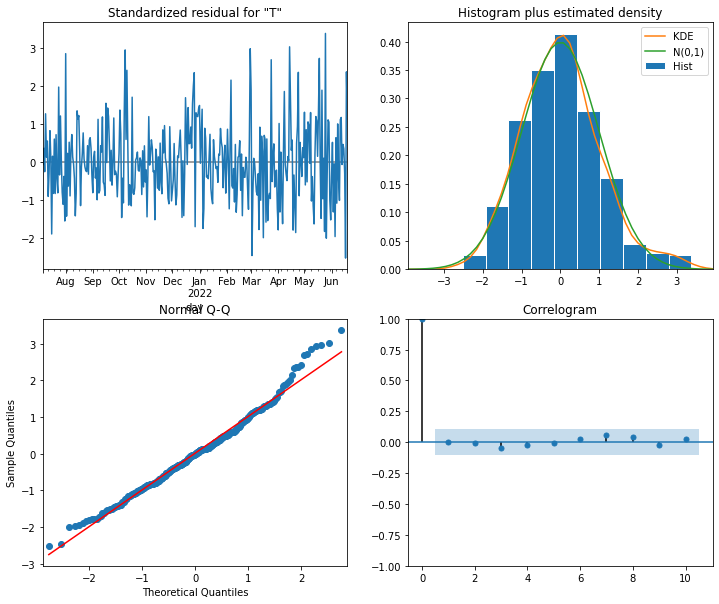

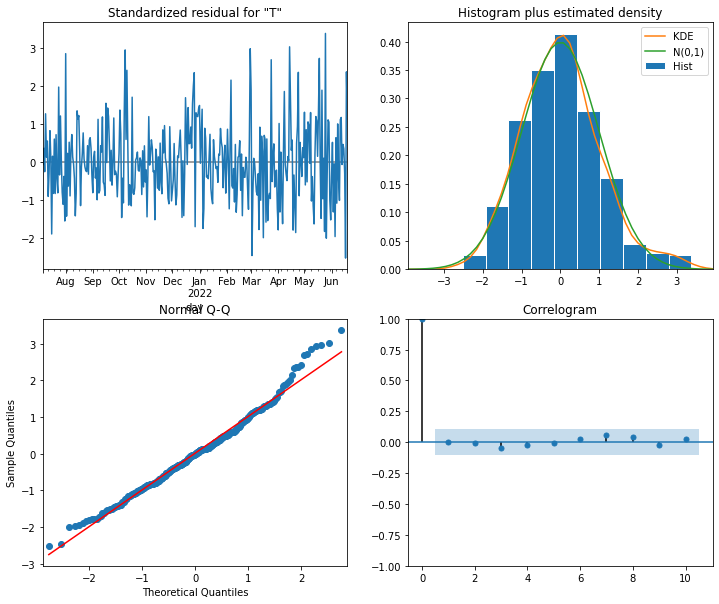

In [121]:
modelo_auto_fit.plot_diagnostics(figsize=(12,10))

In [122]:
plot_prediction(df_raw,'resta',prediccion_espectral)

In [123]:
plot_prediction(df_raw,serie_box_cox,prediccion_espectral,True)

In [124]:
evaluar_metricas(df_raw[df_raw['split']=='test'][serie_box_cox], prediccion_espectral.predicted_mean+df_raw[df_raw['split']=='test']['espectral'])

MSE: 0.0022408302777626806
MAE: 0.035915247139674845
RMSE: 0.04733740886194216
MAPE: 0.0221


### Ejemplo de la FFT
Este ejemplo es para validar los valores de los parámetros

In [90]:
# A fin de explicar las relaciones entre la frecuencia de muestreo, la frecuencia de la serie y su relacion con la tranformada se
# realiza la transformacion de una funcion simple como lo es el seno

fm=1000 #muestras por segundos
Tm=1/fm
n=np.arange(0,1000)
f=250 # frecuencia de la serie [Hz] por el teorema de Nyquist debe ser menor a la mitad de la frecuencia de muestreo
T=1/f # periodo de la serie
x_n=2*np.sin(2*np.pi*n*Tm/T)  #la representación de sin(2*pi*t) ->sin(2*pi*n*Tm)  ó sin(2*pi*n/fm)
N=len(x_n)

X_f = fft(x_n)/N


print(len(n))
k=np.concatenate([np.arange(0,N/2), np.arange(-N/2,0)]) # La funcion fft da las frecuences 0 a fn y -fn a 0 siendo fn la frecuencia de Nyquist
s=k/N*fm

fig = go.Figure()
fig.add_trace(
    go.Scatter( x=s,y=pd.Series(np.imag(X_f)),
                    mode='lines',yaxis='y1',
                    name="Imaginaria")
)

fig.update_layout(height=500, width=1000, title_text="Analisis espectral de una funcion seno "+serie_elegida,#create 1st y axis             
                  yaxis=dict(
                      title="Potencia"),
                  )
fig.show()

1000
